# Case Study 3

Housing price predictions.

# Imports and Dataframe Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import heapq
import joblib
import random
import xgboost as xgb
from IPython.display import display
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, root_mean_squared_error, mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, root_mean_squared_log_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from datetime import datetime

In [3]:
housing = pd.read_csv('./Module 3/housing.csv')
test = pd.read_csv('./Module 3/housing_holdout_test_mini.csv')
test_targets = pd.read_csv('./Module 3/housing_holdout_test_mini_answers.csv')

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             20000 non-null  int64  
 1   date           20000 non-null  object 
 2   bedrooms       20000 non-null  int64  
 3   bathrooms      20000 non-null  float64
 4   sqft_living    20000 non-null  int64  
 5   sqft_lot       20000 non-null  int64  
 6   floors         20000 non-null  float64
 7   waterfront     20000 non-null  int64  
 8   view           20000 non-null  int64  
 9   condition      20000 non-null  int64  
 10  grade          20000 non-null  int64  
 11  sqft_above     20000 non-null  int64  
 12  sqft_basement  20000 non-null  int64  
 13  yr_built       20000 non-null  int64  
 14  yr_renovated   20000 non-null  int64  
 15  zipcode        20000 non-null  int64  
 16  lat            20000 non-null  float64
 17  long           20000 non-null  float64
 18  sqft_l

In [5]:
def combine_date(year, month, day):
    start_date = datetime(int(year), 1, 1)
    end_date = datetime(int(year) + 1, 1, 1)
    total_days = (end_date - start_date).days

    current_date = datetime(int(year), int(month), int(day))
    days_in_year = (current_date - start_date).days

    decimal_year = year + (float(days_in_year) / float(total_days))

    return decimal_year

In [6]:
df_mod = housing.drop(columns=['date', 'id'])
df_mod['year'] = housing['date'].str[:4].astype(int)
df_mod['month'] = housing['date'].str[4:6].astype(int)
df_mod['day'] = housing['date'].str[6:8].astype(int)
df_mod['time'] = df_mod.apply(lambda row: combine_date(row['year'], row['month'], row['day']), axis=1)

test_mod = test.drop(columns=['date', 'id'])
test_mod['year'] = test['date'].str[:4].astype(int)
test_mod['month'] = test['date'].str[4:6].astype(int)
test_mod['day'] = test['date'].str[6:8].astype(int)
test_mod['time'] = test_mod.apply(lambda row: combine_date(row['year'], row['month'], row['day']), axis=1)


# 2014: %4.31, 4.17
# 2015: %3.99, 3.85

In [7]:
rates = pd.DataFrame({
    'year':[2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015],
    'month': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'rate': [0.04588, 0.04388, 0.044, 0.04435, 0.04311, 0.04226, 0.04203, 0.04211, 0.04207, 0.04154, 0.04095, 0.04023, 0.03893, 0.03851, 0.03914, 0.03786, 0.03907, 0.04051, 0.04127, 0.04004, 0.03978, 0.03895, 0.03988, 0.0401]
})

df_mod = pd.merge(df_mod, rates[['year', 'month', 'rate']], on=['year', 'month'], how='left')
test_mod = pd.merge(test_mod, rates[['year', 'month', 'rate']], on=['year', 'month'], how='left')

In [8]:
df_mod.head(5)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,lat,long,sqft_living15,sqft_lot15,price,year,month,day,time,rate
0,4,3.25,3760,4675,2.0,0,0,3,8,2740,...,47.3862,-122.048,3280,4033,429900.0,2014,11,4,2014.841096,0.04095
1,3,1.75,1460,7800,1.0,0,0,2,7,1040,...,47.3035,-122.382,1310,7865,233000.0,2015,1,15,2015.038356,0.03893
2,4,1.00,1340,5800,1.5,0,2,3,7,1340,...,47.5658,-122.389,1900,5800,455000.0,2014,10,14,2014.783562,0.04154
3,3,1.75,1440,8050,1.0,0,0,3,8,1440,...,47.3187,-122.390,1790,7488,258950.0,2014,12,8,2014.934247,0.04023
4,2,1.50,1780,4750,1.0,0,0,4,7,1080,...,47.6859,-122.395,1690,5962,555000.0,2014,8,15,2014.619178,0.04211


In [9]:
# Binning the lot size reduced accuracy
# num_bins = 5
# df_mod['lot_binned'] = pd.cut(df_mod['sqft_lot'], bins=num_bins)
# df_mod['lot15_binned'] = pd.cut(df_mod['sqft_lot15'], bins=num_bins)
# test_mod['lot_binned'] = pd.cut(test_mod['sqft_lot'], bins=num_bins)
# test_mod['lot15_binned'] = pd.cut(test_mod['sqft_lot15'], bins=num_bins)

In [10]:
df_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       20000 non-null  int64  
 1   bathrooms      20000 non-null  float64
 2   sqft_living    20000 non-null  int64  
 3   sqft_lot       20000 non-null  int64  
 4   floors         20000 non-null  float64
 5   waterfront     20000 non-null  int64  
 6   view           20000 non-null  int64  
 7   condition      20000 non-null  int64  
 8   grade          20000 non-null  int64  
 9   sqft_above     20000 non-null  int64  
 10  sqft_basement  20000 non-null  int64  
 11  yr_built       20000 non-null  int64  
 12  yr_renovated   20000 non-null  int64  
 13  zipcode        20000 non-null  int64  
 14  lat            20000 non-null  float64
 15  long           20000 non-null  float64
 16  sqft_living15  20000 non-null  int64  
 17  sqft_lot15     20000 non-null  int64  
 18  price 

In [58]:
X = df_mod.drop(columns=['price'])
X['zipcode'] = X['zipcode'].astype('category')
y = df_mod['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=117)

In [59]:
model = xgb.XGBRFRegressor(random_state=117, enable_categorical=True)
model.fit(X_train, y_train)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None, device=None,
               early_stopping_rounds=None, enable_categorical=True,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=117, reg_alpha=None, ...)

<Axes: title={'center': 'Feat. Import. - Weight'}, xlabel='F score', ylabel='Features'>

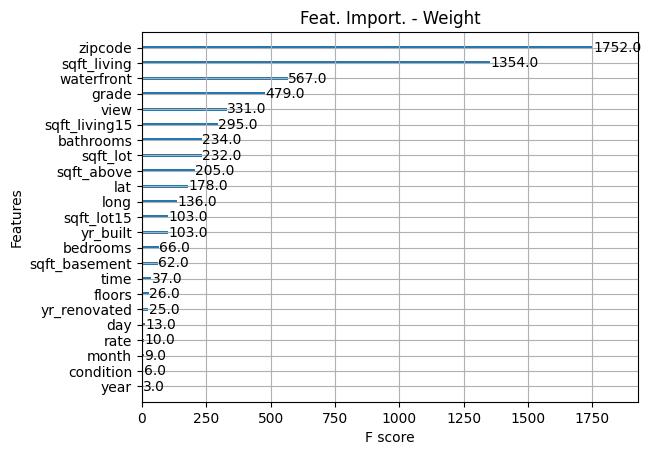

In [60]:
xgb.plot_importance(model, importance_type='weight', title='Feat. Import. - Weight')

<Axes: title={'center': 'Feat. Import. - Gain'}, xlabel='F score', ylabel='Features'>

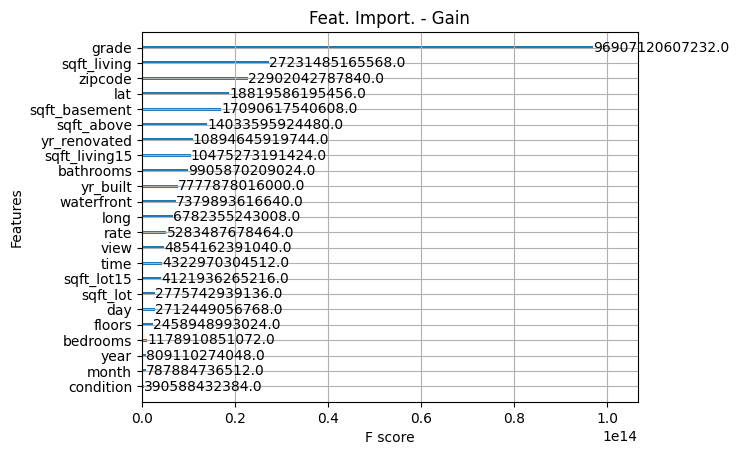

In [61]:
xgb.plot_importance(model, importance_type='gain', title='Feat. Import. - Gain')

In [62]:
pred = model.predict(test_mod)
pred_data = pd.DataFrame(pred)
pred_data.to_csv('./Module 3/team7-module3-predictions.csv', index=False)

In [63]:
rmse = root_mean_squared_error(test_targets, pred)
mse = mean_squared_error(test_targets, pred)
meanae = mean_absolute_error(test_targets, pred)
medae = median_absolute_error(test_targets, pred)
r2 = r2_score(test_targets, pred)

In [64]:
print(f"Root Mean Squared Error (RMSE): {rmse:.5f}")
print(f"Mean Squared Error (MSE): {mse:.5f}")
print(f"Mean Absolute Error (MAE): {meanae:.5f}")
print(f"Median Absolute Error (MAE): {medae:.5f}")
print(f"R^2 Error (R^2): {r2:.5f}")

Root Mean Squared Error (RMSE): 380918.40364
Mean Squared Error (MSE): 145098830233.41974
Mean Absolute Error (MAE): 345926.10340
Median Absolute Error (MAE): 342401.12500
R^2 Error (R^2): -0.77585


# Interaction Combinations
Adding interaction combinations interacting two elements at a time.
This is 276 combinations.

In [69]:
feats = df_mod.drop(columns=['price', 'zipcode']).columns
mdl_combis = []
mdls = []
combi_stats = pd.DataFrame(columns=['Interaction', 'Mean_Abs', 'Med_Abs', 'R2'])
combi_count = 2


for combi in itertools.combinations(feats, combi_count):
    mdl_combis.append(list(combi))

In [70]:
y_tmp = df_mod['price']

for i in range(0, len(mdl_combis)):
    combi_model = xgb.XGBRFRegressor(random_state=117, enable_categorical=True)
    
    X_tmp = df_mod.copy().drop(columns=['price'])
    X_tmp['zipcode'] = X_tmp['zipcode'].astype('category')
    temp_test = test_mod.copy()
    temp_test['zipcode'] = temp_test['zipcode'].astype('category')
    nm = mdl_combis[i][0] + "_x_" + mdl_combis[i][1]
    X_tmp[nm] = X_tmp[mdl_combis[i][0]] * X_tmp[mdl_combis[i][1]]
    temp_test[nm] = temp_test[mdl_combis[i][0]] * temp_test[mdl_combis[i][1]]
    X_tmp_trn, X_tmp_tst, y_tmp_trn, y_tmp_tst = train_test_split(X_tmp, y_tmp, test_size=0.2, random_state=117)

    combi_model.fit(X_tmp_trn, y_tmp_trn)
    mdls.append(combi_model)
    pred = combi_model.predict(temp_test)
    mean_er = mean_absolute_error(test_targets, pred)
    med_er = median_absolute_error(test_targets, pred)
    r2_er = r2_score(test_targets, pred)
    new_data = pd.DataFrame([[nm, mean_er, med_er, r2_er]], columns=['Interaction', 'Mean_Abs', 'Med_Abs', 'R2'])
    combi_stats = pd.concat([combi_stats, new_data], ignore_index=True)

C:\Users\Zhenterigone\AppData\Local\Temp\ipykernel_26724\2693729377.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combi_stats = pd.concat([combi_stats, new_data], ignore_index=True)


In [71]:
combi_sort_R2 = combi_stats.sort_values(by='R2', ascending=False)

In [72]:
combi_sort_R2.head(25)

,Interaction,Mean_Abs,Med_Abs,R2
145,grade_x_long,132758.939429,95973.25000,0.594494
25,bathrooms_x_view,148023.517554,115278.43750,0.480422
27,bathrooms_x_grade,152533.654321,117995.37500,0.480398
102,waterfront_x_lat,150678.549190,115489.71875,0.476907
95,waterfront_x_view,150948.955440,115140.18750,0.475590
97,waterfront_x_grade,150755.723765,115999.56250,0.472830
24,bathrooms_x_waterfront,151652.893711,116589.50000,0.471290
113,view_x_sqft_above,154015.491319,118535.81250,0.465757
44,sqft_living_x_view,153477.604938,116731.68750,0.465213
104,waterfront_x_sqft_living15,152716.655671,113218.75000,0.464460


# Custom interactions

In [ ]:
# sqft_living_x_grade
# sqft_above_x_sqft_basement
# bedrooms_x_bathrooms
# sqft_living_x_age
# long_x_lat ?
# grade_x_long ?
# sqft_living_x_yr_renovated ?

In [52]:
zip_grps = df_mod.groupby('zipcode')['price'].median()
zip_df = zip_grps.reset_index()
zip_df = zip_df.rename(columns={'price': 'zip_median'})
zip_df = pd.merge(zip_df, (df_mod.groupby('zipcode')['price'].mean()).reset_index())
zip_df = zip_df.rename(columns={'price': 'zip_mean'})

quart_bin, quart_ar = pd.qcut(df_mod['price'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'], retbins=True)
zip_df['median_quartile'] = zip_df['zip_median'].map(lambda x: 'Q1' if x <= quart_ar[1] else 'Q2' if x <= quart_ar[2] else 'Q3' if x <= quart_ar[3] else 'Q4').astype('category')
zip_df['mean_quartile'] = zip_df['zip_mean'].map(lambda x: 'Q1' if x <= quart_ar[1] else 'Q2' if x <= quart_ar[2] else 'Q3' if x <= quart_ar[3] else 'Q4').astype('category')

# quart_bin.head(5)
display(zip_df.head(25))
display(quart_ar)

,zipcode,zip_median,zip_mean,median_quartile,mean_quartile
0,98001,260000.0,2.823356e+05,Q1,Q1
1,98002,235000.0,2.350855e+05,Q1,Q1
2,98003,268000.0,2.964844e+05,Q1,Q1
3,98004,1162500.0,1.361288e+06,Q4,Q4
4,98005,760000.0,8.028689e+05,Q4,Q4
5,98006,770000.0,8.716258e+05,Q4,Q4
6,98007,550000.0,6.111963e+05,Q3,Q3
7,98008,546800.0,6.511046e+05,Q3,Q4
8,98010,372000.0,4.327239e+05,Q2,Q2
9,98011,470000.0,4.901008e+05,Q3,Q3


array([  75000.,  322000.,  450000.,  641625., 7700000.])

In [53]:
X_cust = X.copy()
X_cust = pd.merge(X_cust, zip_df[['zipcode', 'zip_median', 'zip_mean', 'median_quartile', 'mean_quartile']], on=['zipcode'], how='left')
y_cust = y.copy()
cust_test = test_mod.copy()
cust_test = pd.merge(cust_test, zip_df[['zipcode', 'zip_median', 'zip_mean', 'median_quartile', 'mean_quartile']], on=['zipcode'], how='left')


# X_cust['sqft_living_x_yr_renovated'] = X_cust['sqft_living'] * X_cust['yr_renovated']
# X_cust['grade_long'] = X_cust['grade'] * X_cust['long']
# X_cust['waterfront_time'] = X_cust['waterfront'] * X_cust['time']
# X_cust['waterfront_x_view'] = X_cust['waterfront'] * X_cust['view']
# X_cust['grade_x_sqft_living'] = X_cust['grade'] * X_cust['sqft_living']
# X_cust['long_x_lat'] = X_cust['long'] * X_cust['lat']
# X_cust['bathrooms_x_bedrooms'] = X_cust['bathrooms'] * X_cust['bedrooms']
# X_cust['total_sqft'] = X_cust['sqft_above'] + X_cust['sqft_basement'] + X_cust['sqft_living']
# cust_test['sqft_living_x_yr_renovated'] = temp_test['sqft_living'] * temp_test['yr_renovated']
# cust_test['grade_long'] = temp_test['grade'] * temp_test['long']
# cust_test['waterfront_time'] = temp_test['waterfront'] * temp_test['time']
# cust_test['waterfront_x_view'] = cust_test['waterfront'] * cust_test['view']
# cust_test['grade_x_sqft_living'] = cust_test['grade'] * cust_test['sqft_living']
# cust_test['long_x_lat'] = temp_test['long'] * temp_test['lat']
# cust_test['bathrooms_x_bedrooms'] = cust_test['bathrooms'] * cust_test['bedrooms']
# cust_test['total_sqft'] = cust_test['sqft_above'] + cust_test['sqft_basement'] + cust_test['sqft_living']

In [54]:
X_cust_trn, X_cust_tst, y_cust_trn, y_cust_tst = train_test_split(X_cust, y_cust, test_size=0.2, random_state=172)
model_cust = xgb.XGBRFRegressor(random_state=46, enable_categorical=True)
model_cust.fit(X_cust_trn, y_cust_trn)
pred_cust = model_cust.predict(cust_test)

In [55]:
meanae_cust = mean_absolute_error(test_targets, pred_cust)
medae_cust = median_absolute_error(test_targets, pred_cust)
r2_cust = r2_score(test_targets, pred_cust)

In [56]:
print(f"Mean Absolute Error (MAE): {meanae_cust:.5f}")
print(f"Median Absolute Error (MAE): {medae_cust:.5f}")
print(f"R^2 Error (R^2): {r2_cust:.5f}")

Mean Absolute Error (MAE): 91871.14333
Median Absolute Error (MAE): 48887.93750
R^2 Error (R^2): 0.70572


<Axes: title={'center': 'Feat. Import. - Gain'}, xlabel='F score', ylabel='Features'>

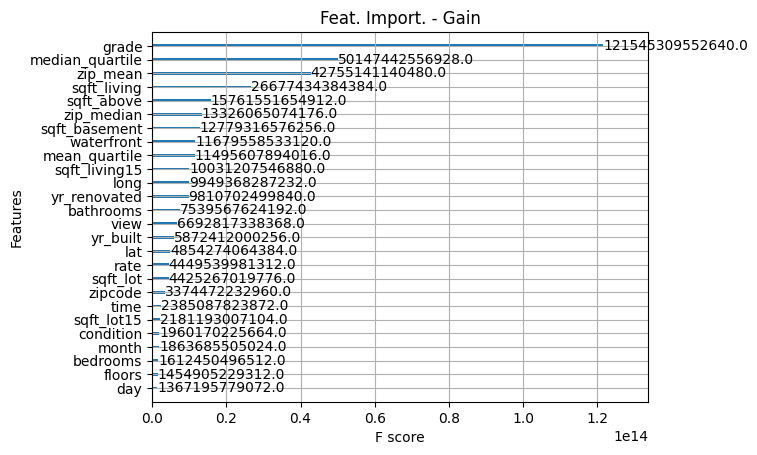

In [57]:
xgb.plot_importance(model_cust, importance_type='gain', title='Feat. Import. - Gain')

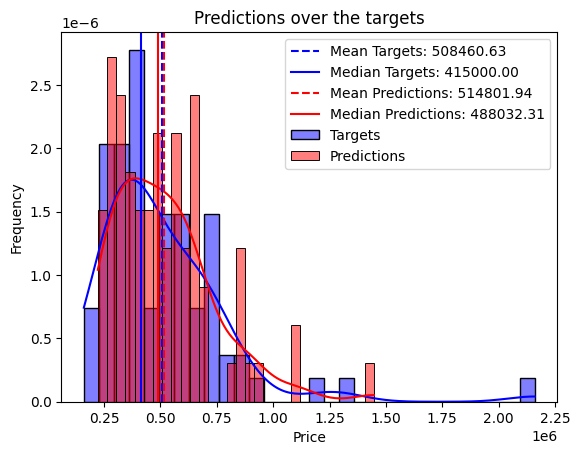

In [172]:
mean_targets = np.mean(test_targets['price'])
median_targets = np.median(test_targets['price'])
mean_pred_cust = np.mean(pred_cust)
median_pred_cust = np.median(pred_cust)

sns.histplot(test_targets['price'], color='blue', kde=True, label='Targets', stat='density', bins=30)
sns.histplot(pred_cust, color='red', kde=True, label='Predictions', stat='density', bins=30)


plt.axvline(mean_targets, color='blue', linestyle='--', label=f'Mean Targets: {mean_targets:.2f}')
plt.axvline(median_targets, color='blue', linestyle='-', label=f'Median Targets: {median_targets:.2f}')
plt.axvline(mean_pred_cust, color='red', linestyle='--', label=f'Mean Predictions: {mean_pred_cust:.2f}')
plt.axvline(median_pred_cust, color='red', linestyle='-', label=f'Median Predictions: {median_pred_cust:.2f}')


# Add labels and title
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Predictions over the targets')
plt.legend()

# Show the plot
plt.show()


In [140]:
# X['zipcode'].value_counts()
# df_mod['price'].describe()
df_mod.groupby('zipcode')['price'].mean()

zipcode
98001    2.823356e+05
98002    2.350855e+05
98003    2.964844e+05
98004    1.361288e+06
98005    8.028689e+05
             ...     
98177    6.855902e+05
98178    3.111454e+05
98188    2.860481e+05
98198    3.021579e+05
98199    7.825758e+05
Name: price, Length: 70, dtype: float64

# County Census

In [90]:
county = pd.read_csv('./Module 3/king_county_acs.csv')

In [91]:
county.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66240 entries, 0 to 66239
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   NAME                      66240 non-null  object 
 1   median_income             62964 non-null  float64
 2   poverty_total             66240 non-null  int64  
 3   poverty_below             66240 non-null  int64  
 4   total_population          66240 non-null  int64  
 5   age_under_5               66240 non-null  int64  
 6   age_5_to_9                66240 non-null  int64  
 7   white_alone               66240 non-null  int64  
 8   black_alone               66240 non-null  int64  
 9   asian_alone               66240 non-null  int64  
 10  hispanic_origin           66240 non-null  int64  
 11  total_housing_units       66240 non-null  int64  
 12  owner_occupied            66240 non-null  int64  
 13  edu_total                 66240 non-null  int64  
 14  edu_hi

In [96]:
df_county = df_mod.copy()
test_county = test_mod.copy()

In [ ]:
# median_income
# poverty_total
# poverty_below
# total_population
# edu_total
# edu_high_school
# edu_bachelor
# labor_force_total
# employed
# year
# zipcode


In [97]:
df_county = pd.merge(df_county, county[['median_income', 'poverty_total', 'poverty_below', 'total_population', 'edu_total', 'edu_high_school', 'edu_bachelor', 'labor_force_total', 'employed', 'year', 'zipcode']], on=['year', 'zipcode'], how='left')
test_county = pd.merge(test_county, county[['median_income', 'poverty_total', 'poverty_below', 'total_population', 'edu_total', 'edu_high_school', 'edu_bachelor', 'labor_force_total', 'employed', 'year', 'zipcode']], on=['year', 'zipcode'], how='left')

In [98]:
X_county = df_county.drop(columns=['price'])
y_county = df_county['price']

X_trn_county, X_tst_county, y_trn_county, y_tst_county = train_test_split(X_county, y_county, test_size=0.2, random_state=117)

model_county = xgb.XGBRFRegressor(random_state=117, enable_categorical=True)
model_county.fit(X_trn_county, y_trn_county)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None, device=None,
               early_stopping_rounds=None, enable_categorical=True,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=117, reg_alpha=None, ...)

In [99]:
pred_county = model_county.predict(test_county)

rmse_count = root_mean_squared_error(test_targets, pred_county)
mse_count = mean_squared_error(test_targets, pred_county)
meanae_count = mean_absolute_error(test_targets, pred_county)
medae_count = median_absolute_error(test_targets, pred_county)
r2_count = r2_score(test_targets, pred_county)

In [100]:
print(f"Root Mean Squared Error (RMSE): {rmse_count:.5f}")
print(f"Mean Squared Error (MSE): {mse_count:.5f}")
print(f"Mean Absolute Error (MAE): {meanae_count:.5f}")
print(f"Median Absolute Error (MAE): {medae_count:.5f}")
print(f"R^2 Error (R^2): {r2_count:.5f}")

Root Mean Squared Error (RMSE): 136287.71732
Mean Squared Error (MSE): 18574341892.85490
Mean Absolute Error (MAE): 81581.26331
Median Absolute Error (MAE): 48071.50000
R^2 Error (R^2): 0.77267


<Axes: title={'center': 'Feat. Import. - Gain'}, xlabel='F score', ylabel='Features'>

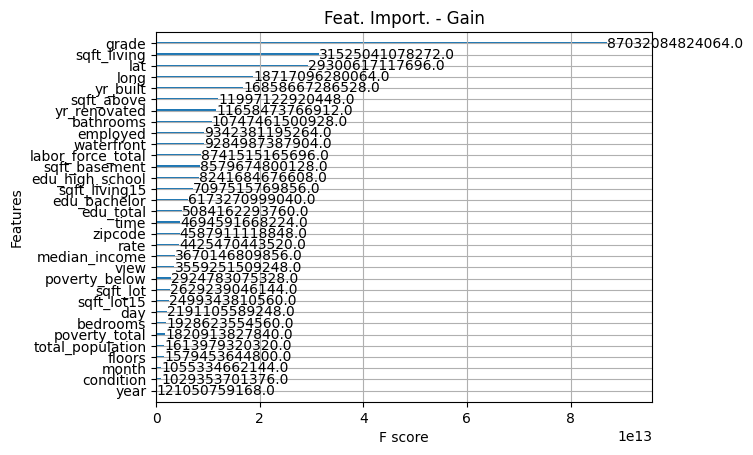

In [101]:
xgb.plot_importance(model_county, importance_type='gain', title='Feat. Import. - Gain')

# Looping through random numbers

In [25]:
rdm_mdls = []
rdm_combis = []
rdm_nmbrs = []
rdm_stats = pd.DataFrame(columns=['Random Split', 'Random Model', 'Mean_Abs', 'Med_Abs', 'R2'])

# DO NOT LET THE RANGE GO HIGH, REMEMBER n!, n over 150 is undefined because it is too big, limit to at most 100
# 
for i in range(100):
    ran_int = random.randint(1, 10000)
    rdm_nmbrs.append(ran_int)

for combi in itertools.combinations(rdm_nmbrs, 2):
    rdm_combis.append(list(combi))

In [26]:
X_rdm = df_mod.copy().drop(columns=['price'])
y_rdm = df_mod['price']

for i in range(0, len(rdm_combis)):
    combi_model = xgb.XGBRFRegressor(random_state=rdm_combis[i][1], enable_categorical=True)
    X_tmp_trn, X_tmp_tst, y_tmp_trn, y_tmp_tst = train_test_split(X_rdm, y_rdm, test_size=0.2, random_state=rdm_combis[i][0])

    temp_test = test_mod.copy()
    combi_model.fit(X_tmp_trn, y_tmp_trn)
    rdm_mdls.append(combi_model)
    pred = combi_model.predict(temp_test)
    mean_er = mean_absolute_error(test_targets, pred)
    med_er = median_absolute_error(test_targets, pred)
    r2_er = r2_score(test_targets, pred)
    new_data = pd.DataFrame([[rdm_combis[i][0], rdm_combis[i][1], mean_er, med_er, r2_er]], columns=['Random Split', 'Random Model', 'Mean_Abs', 'Med_Abs', 'R2'])
    rdm_stats = pd.concat([rdm_stats, new_data], ignore_index=True)

C:\Users\Zhenterigone\AppData\Local\Temp\ipykernel_26724\13663958.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rdm_stats = pd.concat([rdm_stats, new_data], ignore_index=True)


In [27]:
rdm_combi_sort_R2 = rdm_stats.sort_values(by='R2', ascending=False)

In [28]:
rdm_combi_sort_R2.head(5)

,Random Split,Random Model,Mean_Abs,Med_Abs,R2
1360,4245,2053,84426.573881,55294.000000,0.780014
2034,3709,8682,83038.384259,55214.796875,0.779399
2108,4700,5230,86249.284915,56749.062500,0.778272
3873,8725,8025,85500.728588,58699.906250,0.777988
2842,8682,8639,81940.364969,53968.437500,0.775603


In [29]:
rdm_combi_sort_R2.tail(5)

,Random Split,Random Model,Mean_Abs,Med_Abs,R2
4390,6832,6838,94028.492284,60893.281250,0.664613
4877,3138,753,93362.888117,59612.125000,0.662181
802,4413,2376,90706.209491,51286.343750,0.662094
4882,3138,1519,92378.618248,58400.375000,0.662005
4872,3138,4476,94745.800540,56972.671875,0.655992


# Multi Level Interaction Combinations

In [ ]:
feats = df_mod.drop(columns=['price']).columns
mdl_combis = []
mdls = []
combi_stats = pd.DataFrame(columns=['Interaction 1', 'Interaction 2', 'Interaction 3', 'Mean_Abs', 'Med_Abs', 'R2'])
combi_count = 2


for combi in itertools.combinations(feats, combi_count):
    mdl_combis.append(list(combi))

In [ ]:
y_tmp = df_mod['price']

for i in range(0, len(mdl_combis)):
    combi_model = xgb.XGBRFRegressor(random_state=117, enable_categorical=True)
    
    X_tmp = df_mod.copy().drop(columns=['price'])
    temp_test = test_mod.copy()
    nm = mdl_combis[i][0] + "_x_" + mdl_combis[i][1]
    X_tmp[nm] = X_tmp[mdl_combis[i][0]] * X_tmp[mdl_combis[i][1]]
    temp_test[nm] = temp_test[mdl_combis[i][0]] * temp_test[mdl_combis[i][1]]
    X_tmp_trn, X_tmp_tst, y_tmp_trn, y_tmp_tst = train_test_split(X_tmp, y_tmp, test_size=0.2, random_state=117)

    combi_model.fit(X_tmp_trn, y_tmp_trn)
    mdls.append(combi_model)
    pred = combi_model.predict(temp_test)
    mean_er = mean_absolute_error(test_targets, pred)
    med_er = median_absolute_error(test_targets, pred)
    r2_er = r2_score(test_targets, pred)
    new_data = pd.DataFrame([[nm, mean_er, med_er, r2_er]], columns=['Interaction', 'Mean_Abs', 'Med_Abs', 'R2'])
    combi_stats = pd.concat([combi_stats, new_data], ignore_index=True)

In [ ]:
combi_sort_R2 = combi_stats.sort_values(by='R2', ascending=False)
combi_sort_R2.head(5)